# Brain Tumor MRI Classification

This notebook implements **InceptionNetV2** and **DenseNet201** models to classify brain MRI images into four classes: Glioma, Meningioma, Pituitary, and No Tumor.  

The workflow includes:
- Loading and preprocessing datasets
- Data augmentation
- Model training and fine-tuning
- Evaluation (accuracy, confusion matrix, classification report)



In [34]:
from google.colab import drive
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,Model
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import AdamW
from keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from keras.preprocessing import image_dataset_from_directory

from keras.applications import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input

from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
from tensorflow.keras import mixed_precision



---

### 📥 Dataset Download

This project uses the **Brain Tumor MRI Dataset (Glioma, Meningioma, Pituitary, No Tumor)** available on **Mendeley Data**.

**Download Link:**
[https://data.mendeley.com/datasets/zwr4ntf94j](https://data.mendeley.com/datasets/zwr4ntf94j)

The dataset contains MRI images organised into **train** and **test** folders, with four tumour classes. After downloading, extract the archive and update the dataset path in the notebook accordingly.

---


In [2]:
#load the dataset from google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_dir = '/content/drive/MyDrive/Brain Tumor Data/Epic and CSCR hospital Dataset'
train_dir = os.path.join(data_dir,'Train')
test_dir = os.path.join(data_dir,'Test')

## 1. Dataset Loading
Here we load the MRI images using TensorFlow's `image_dataset_from_directory` and split them into training and test datasets.



In [4]:
# Constants
BATCH_SIZE = 32
IMAGE_SIZE = (299,299) #Resize for InceptionResNetV2

In [5]:
train_ds = image_dataset_from_directory(
   train_dir,
   image_size = IMAGE_SIZE,
   batch_size = BATCH_SIZE,
   shuffle = True,
)

test_ds = image_dataset_from_directory(
    test_dir,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    shuffle = False
)

Found 9650 files belonging to 4 classes.
Found 2414 files belonging to 4 classes.


In [6]:
images,labels = next(iter(train_ds))

print("batch shape",images.shape)
print("labels shape",labels.shape)


#map label indices to class names

class_names = train_ds.class_names
print(class_names)

batch shape (32, 299, 299, 3)
labels shape (32,)
['glioma', 'meningioma', 'notumor', 'pituitary']


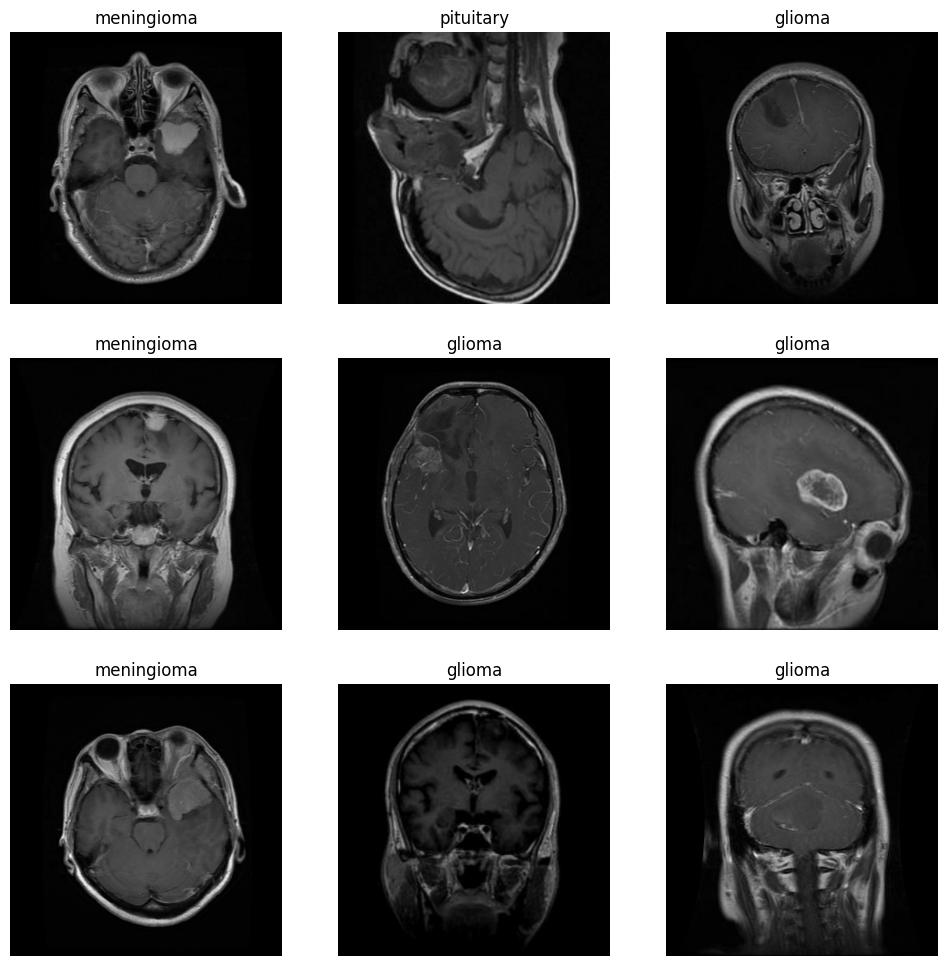

In [7]:

plt.figure(figsize=(12,12))
for i in range(9):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(images[i].numpy().astype("uint8"))
  plt.title(class_names[labels[i]])
  plt.axis("off")
plt.show()

## Prospective Models

- InceptionResNetV2
- DenseNet201



##InceptionResNetV2



### Data Augmentation
We apply horizontal flipping, rotation, and zoom to improve model generalization.


In [8]:
#Augmentation

data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1)
]
)

In [9]:
#Prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [10]:
base = InceptionResNetV2(include_top=False, weights='imagenet',input_shape=(299,299,3))
base.trainable = False #freeze first phase

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [11]:
#add classification head

inputs = keras.Input(shape=(299,299,3))
x = data_augmentation(inputs)
x = keras.applications.inception_resnet_v2.preprocess_input(x)


x = base(x,training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(4, activation= "softmax")(x)

model = keras.Model(inputs,outputs)

In [13]:
#compile

model.compile(
    optimizer = keras.optimizers.Adam(1e-4),
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)


callbacks = [
    keras.callbacks.EarlyStopping(
        monitor = 'val_loss',
        patience = 5,
        restore_best_weights = True
    ),

    keras.callbacks.ModelCheckpoint('best_model_phase1.keras',monitor ='val_loss',save_best_only=True)
]

#Train the model(base frozen)

history_phase1=model.fit(
    train_ds,
    validation_data = test_ds,
    epochs = 15,
    callbacks = callbacks
)

Epoch 1/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 215s 658ms/step - accuracy: 0.5518 - loss: 1.0680 - val_accuracy: 0.6972 - val_loss: 0.8204
Epoch 2/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 51s 170ms/step - accuracy: 0.6882 - loss: 0.8305 - val_accuracy: 0.7113 - val_loss: 0.7310
Epoch 3/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 51s 170ms/step - accuracy: 0.7230 - loss: 0.7357 - val_accuracy: 0.7220 - val_loss: 0.6906
Epoch 4/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 52s 171ms/step - accuracy: 0.7469 - loss: 0.6839 - val_accuracy: 0.7299 - val_loss: 0.6674
Epoch 5/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 52s 171ms/step - accuracy: 0.7592 - loss: 0.6463 - val_accuracy: 0.7361 - val_loss: 0.6425
Epoch 6/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 52s 172ms/step - accuracy: 0.7745 - loss: 0.6108 - val_accuracy: 0.7436 - val_loss: 0.6296
Epoch 7/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 51s 169ms/step - accuracy: 0.7765 - loss: 0.5984 - val_accuracy: 0.7436 - val_loss: 0.6191
Epoch 8/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 51s 169ms/step - accuracy: 0.7820 - loss: 

Phase 2: FInetuning with AdamW

In [14]:

#unfreeze top layers of the base
base.trainable = True
#freeze lower layers,finetune top layers only
for layer in base.layers[:-100]:
  layer.trainable = False
#compile with AdmaW

model.compile(
    optimizer = AdamW(learning_rate=1e-5,weight_decay=1e-4),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

callbacks_phase2 = [
    keras.callbacks.EarlyStopping(
        monitor= 'val_loss',
        patience=5,
        restore_best_weights=True
    ),

    keras.callbacks.ModelCheckpoint('best_model_phase2.keras',monitor='val_loss',save_best_only=True)
]

history_phase2 = model.fit(
    train_ds,
    validation_data = test_ds,
    epochs = 10,
    callbacks = callbacks_phase2
)



Epoch 1/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 102s 235ms/step - accuracy: 0.7783 - loss: 0.6406 - val_accuracy: 0.8061 - val_loss: 0.4869
Epoch 2/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 63s 210ms/step - accuracy: 0.8759 - loss: 0.3541 - val_accuracy: 0.8467 - val_loss: 0.3908
Epoch 3/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 63s 210ms/step - accuracy: 0.9180 - loss: 0.2484 - val_accuracy: 0.8592 - val_loss: 0.3735
Epoch 4/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 63s 210ms/step - accuracy: 0.9425 - loss: 0.1760 - val_accuracy: 0.8952 - val_loss: 0.3026
Epoch 5/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 63s 207ms/step - accuracy: 0.9530 - loss: 0.1364 - val_accuracy: 0.9031 - val_loss: 0.2955
Epoch 6/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 63s 208ms/step - accuracy: 0.9637 - loss: 0.1101 - val_accuracy: 0.9147 - val_loss: 0.2572
Epoch 7/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 64s 211ms/step - accuracy: 0.9714 - loss: 0.0861 - val_accuracy: 0.9358 - val_loss: 0.2054
Epoch 8/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 60s 200ms/step - accuracy: 0.9797 - loss: 

In [15]:
model.evaluate(test_ds)

76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 0.9294 - loss: 0.2383


[0.19701367616653442, 0.9436619877815247]

76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 193ms/step


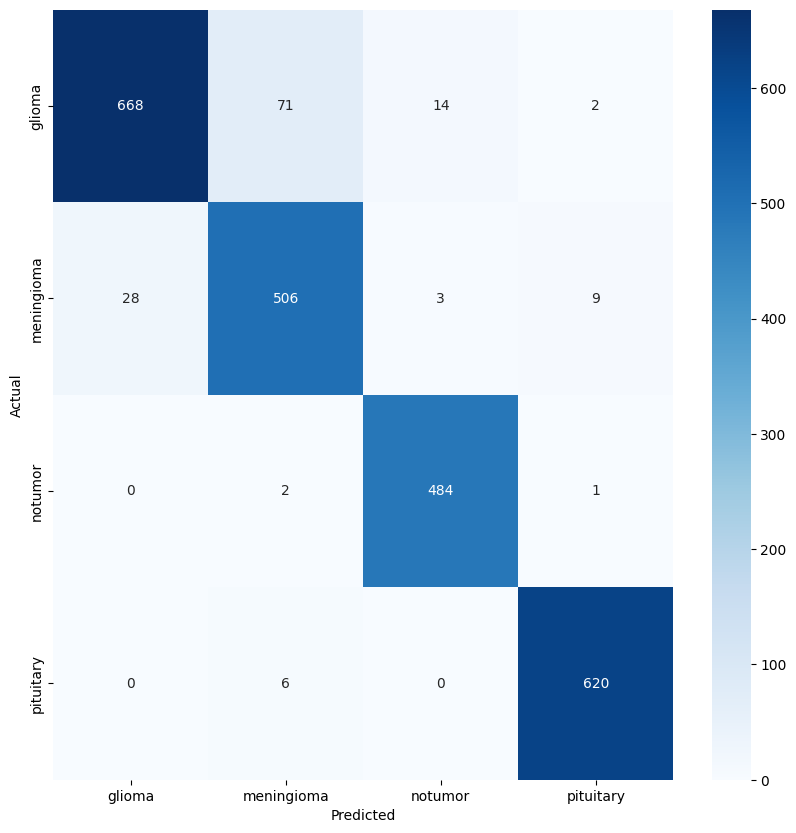

              precision    recall  f1-score   support

      glioma       0.96      0.88      0.92       755
  meningioma       0.86      0.93      0.89       546
     notumor       0.97      0.99      0.98       487
   pituitary       0.98      0.99      0.99       626

    accuracy                           0.94      2414
   macro avg       0.94      0.95      0.95      2414
weighted avg       0.95      0.94      0.94      2414



In [16]:
#Confusion Matrix

class_names = sorted(os.listdir("/content/drive/MyDrive/Brain Tumor Data/Epic and CSCR hospital Dataset/Test"))


labels = np.concatenate([y for x , y in test_ds])
preds = np.argmax(model.predict(test_ds),axis = 1)
cm = confusion_matrix(labels,preds)


plt.figure(figsize=(10,10))
sns.heatmap(cm,annot=True,cmap="Blues",fmt="d",xticklabels=class_names,yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(labels,preds,target_names=class_names))


DenseNet201Base

In [17]:
from tensorflow.keras import backend as K
import gc

K.clear_session()
gc.collect()

0

In [18]:
IMAGE_SIZE_2 = (224,224)
BATCH_SIZE_2 = 32

In [19]:



train_ds = image_dataset_from_directory(
   train_dir,
   image_size = IMAGE_SIZE_2,
   batch_size = BATCH_SIZE_2,
   label_mode = 'int',
   shuffle = True,
)

test_ds = image_dataset_from_directory(
    test_dir,
    image_size = IMAGE_SIZE_2,
    batch_size = BATCH_SIZE_2,
    label_mode = 'int',
    shuffle = False
)






Found 9650 files belonging to 4 classes.
Found 2414 files belonging to 4 classes.


In [20]:
#Prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [21]:
input_shape = (224,224,3)
#load base model with imagenet weights,excluding the top
base = DenseNet201(
    include_top = False,
    weights = 'imagenet',
    input_shape = input_shape
)

base.trainable = False

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [22]:
#Augmentation
inputs= layers.Input(shape=input_shape)
x = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1)
]
)(inputs)

In [23]:
#preprocess input for densenet

from tensorflow.keras.applications.densenet import preprocess_input
x = preprocess_input(x)


#pass through base

x = base(x,training= False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(4,activation="softmax")(x)

model = Model(inputs,outputs)

In [24]:
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer = Adam(1e-4),
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

In [25]:
callbacks_phase1 = [
    keras.callbacks.EarlyStopping(
        monitor = 'val_loss',
        patience = 5,
        restore_best_weights = True
    ),

    keras.callbacks.ModelCheckpoint('best_densenet201_model_phase1.keras',monitor ='val_loss',save_best_only=True)
]

#Train the model(base frozen)

history_phase1=model.fit(
    train_ds,
    validation_data = test_ds,
    epochs = 15,
    callbacks = callbacks_phase1)

Epoch 1/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 84s 212ms/step - accuracy: 0.3405 - loss: 1.4964 - val_accuracy: 0.6114 - val_loss: 0.9612
Epoch 2/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 40s 133ms/step - accuracy: 0.6233 - loss: 0.9322 - val_accuracy: 0.7096 - val_loss: 0.7787
Epoch 3/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 40s 133ms/step - accuracy: 0.7193 - loss: 0.7614 - val_accuracy: 0.7162 - val_loss: 0.7196
Epoch 4/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 40s 133ms/step - accuracy: 0.7496 - loss: 0.6697 - val_accuracy: 0.7307 - val_loss: 0.6630
Epoch 5/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 40s 133ms/step - accuracy: 0.7789 - loss: 0.6031 - val_accuracy: 0.7374 - val_loss: 0.6410
Epoch 6/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 40s 133ms/step - accuracy: 0.7870 - loss: 0.5763 - val_accuracy: 0.7411 - val_loss: 0.6244
Epoch 7/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 40s 133ms/step - accuracy: 0.8006 - loss: 0.5415 - val_accuracy: 0.7572 - val_loss: 0.5866
Epoch 8/15
302/302 ━━━━━━━━━━━━━━━━━━━━ 40s 134ms/step - accuracy: 0.8090 - loss: 0

In [26]:
#phase 2: fine tuning densenet201

In [27]:
base.trainable = True
for layer in base.layers[:-100]:
  layer.trainable = False


In [28]:
#compile with AdamW
model.compile(
    optimizer = AdamW(learning_rate=1e-5,weight_decay=1e-4),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

callbacks_phase2 = [
    keras.callbacks.EarlyStopping(
        monitor= 'val_loss',
        patience=5,
        restore_best_weights=True
    ),

    keras.callbacks.ModelCheckpoint('best_densenet201_model_phase2.keras',monitor='val_loss',save_best_only=True)
]

history_phase2 = model.fit(
    train_ds,
    validation_data = test_ds,
    epochs = 10,
    callbacks = callbacks_phase2
)


Epoch 1/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 100s 203ms/step - accuracy: 0.8007 - loss: 0.5535 - val_accuracy: 0.7945 - val_loss: 0.5199
Epoch 2/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 52s 171ms/step - accuracy: 0.8568 - loss: 0.3997 - val_accuracy: 0.8235 - val_loss: 0.4497
Epoch 3/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 51s 169ms/step - accuracy: 0.8790 - loss: 0.3270 - val_accuracy: 0.8418 - val_loss: 0.4010
Epoch 4/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 51s 169ms/step - accuracy: 0.8947 - loss: 0.2941 - val_accuracy: 0.8546 - val_loss: 0.3693
Epoch 5/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 51s 169ms/step - accuracy: 0.9042 - loss: 0.2667 - val_accuracy: 0.8666 - val_loss: 0.3436
Epoch 6/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 52s 172ms/step - accuracy: 0.9193 - loss: 0.2373 - val_accuracy: 0.8741 - val_loss: 0.3275
Epoch 7/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 51s 169ms/step - accuracy: 0.9273 - loss: 0.2170 - val_accuracy: 0.8811 - val_loss: 0.3128
Epoch 8/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 52s 172ms/step - accuracy: 0.9333 - loss: 

In [29]:
model.evaluate(test_ds)

76/76 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.8703 - loss: 0.3370


[0.2657007575035095, 0.9001656770706177]

In [31]:
#For InceptionNetV2

test_ds_inception = image_dataset_from_directory(
    test_dir,
    image_size =(299,299),
    batch_size = 32,
    label_mode = 'int',
    shuffle = False
)


#For DenseNet201

test_ds_densenet = image_dataset_from_directory(
    test_dir,
    image_size =(224,224),
    batch_size = 32,
    label_mode = 'int',
    shuffle = False
)

Found 2414 files belonging to 4 classes.
Found 2414 files belonging to 4 classes.


In [33]:
from tensorflow.keras.models import load_model

#load InceptionResNetV2 model
inception_model = load_model('best_model_phase2.keras')
#load DenseNet201 model
densenet_model = load_model('best_densenet201_model_phase2.keras')

#Evaluate both models on the same test dataset
loss_inc,acc_inc = inception_model.evaluate(test_ds_inception)
loss_den,acc_den = densenet_model.evaluate(test_ds_densenet)


print(f"InceptionResNetV2 Accuracy : {acc_inc*100:.2f}%")
print(f"DenseNet201 Accuracy:{acc_den*100:.2f}%")

76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 159ms/step - accuracy: 0.9294 - loss: 0.2383
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 99ms/step - accuracy: 0.8703 - loss: 0.3370
InceptionResNetV2 Accuracy : 94.37%
DenseNet201 Accuracy:90.02%
